In [1]:
!pip config set global.index-url https://mirrors.aliyun.com/pypi/simple/
!python -m pip install -U pip
!pip -V
!pip install sklearn pandas

Writing to /root/.config/pip/pip.conf
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.4)
pip 20.2.4 from /usr/local/lib/python3.6/dist-packages/pip (python 3.6)
Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

In [3]:
print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.5
pandas 1.1.3
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [4]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_train_all = x_train_all / 255.0
x_test = x_test / 255.0
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [5]:
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# x_train: [None, 28, 28] -> [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [6]:
# tf.keras.Sequential()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.BatchNormalization())
    '''
    model.add(keras.layers.Dense(100))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    '''
model.add(keras.layers.Dense(10, activation='softmax'))

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3]
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3

# reason for sparse: y->index. y->one_hot->[]
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])


In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               4

In [8]:
# Tensorboard, earlystopping, ModelCheckpoint
logdir = './dnn-bn-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 'fashion_mnist_model.h5')
    
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file,
                                   save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='loss', patience=5,min_delta=1e-3)
]
history = model.fit(x_train_scaled, y_train, epochs=10, 
                    validation_data=(x_valid_scaled, y_valid),
                   callbacks=callbacks)

Epoch 1/10
   1/1719 [..............................] - ETA: 0s - loss: 3.0931 - accuracy: 0.1250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 15s 9ms/step - loss: 1.0582 - accuracy: 0.6131 - val_loss: 0.6892 - val_accuracy: 0.7442
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.7716 - accuracy: 0.7187 - val_loss: 0.5844 - val_accuracy: 0.7782
Epoch 3/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.6789 - accuracy: 0.7540 - val_loss: 0.5364 - val_accuracy: 0.8100
Epoch 4/10
1719/1719 [==============================] - 15s 8ms/step - loss: 0.6069 - accuracy: 0.7848 - val_loss: 0.4702 - val_accuracy: 0.8322
Epoch 5/10
1719/1719 [==============================] - 

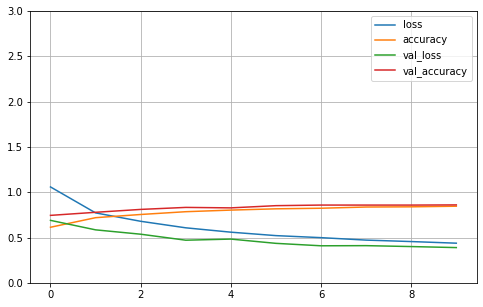

In [9]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()
    
plot_learning_curves(history)

# 1.参数众多，训练不充分
# 2.梯度消失 -> 链式法则 -> 复合函数f(g(x))
#   批归一化缓解梯度消失

In [10]:
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 0s 2ms/step - loss: 0.4204 - accuracy: 0.8493


[0.4204113185405731, 0.8493000268936157]